In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from pathlib import Path
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras import layers, Model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.applications import ResNet50
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from tensorflow.keras.applications.efficientnet import preprocess_input as efficientnet_preprocess
from tensorflow.keras.callbacks import ModelCheckpoint
import xgboost as xgb
import cv2
import seaborn as sns

In [ ]:
train_df = pd.read_csv('path to dataset')
test_df = pd.read_csv('path to dataset')
val_df = pd.read_csv('path to dataset')
to_predict_df = pd.read_csv('path to dataset')

to_predict_df.dropna(inplace=True)

print(f"Training samples: {len(train_df)}")
print(f"Validation samples: {len(val_df)}")
print(f"Test samples: {len(test_df)}")
print(f"To Predict samples: {len(to_predict_df)}")

Training samples: 12967
Validation samples: 1621
Test samples: 1621
To Predict samples: 5403


In [4]:
train_images_df = train_df['image_path'].copy()
train_df.drop('image_path', axis=1, inplace=True)

test_images_df = test_df['image_path'].copy()
test_df.drop('image_path', axis=1, inplace=True)

val_images_df = val_df['image_path'].copy()
val_df.drop('image_path', axis=1, inplace=True)

to_predict__images_df = to_predict_df['image_path'].copy()
to_predict_df.drop('image_path', axis=1, inplace=True)

In [7]:
def load_images(image_paths, target_size=(128, 128)):
    images = []
    failed = []
    for idx in range(len(image_paths)):
        try:
            img = load_img(image_paths.iloc[idx], target_size=target_size)
            img_array = img_to_array(img)
            img_array = img_array / 255.0
            images.append(img_array)
        except Exception as e:
            print(f"Failed to load image {idx}: {e}")
            failed.append(idx)
            images.append(np.zeros((*target_size, 3)))
    return np.array(images), failed

In [8]:
def augment_images(images):
    datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.15,
        height_shift_range=0.15,
        shear_range=0.1,
        zoom_range=0.1,
        horizontal_flip=True,
        fill_mode='nearest'
    )
    
    augmented_images = []
    for img in images:
        img_reshaped = img.reshape((1,) + img.shape)
        aug_iter = datagen.flow(img_reshaped, batch_size=1)
        augmented_images.append(next(aug_iter)[0])
    
    return np.array(augmented_images)

In [9]:
print("Loading images with 128x128 resolution...")
train_images_128, train_failed = load_images(train_images_df, target_size=(128, 128))
test_images_128, test_failed = load_images(test_images_df, target_size=(128, 128))
val_images_128, val_failed = load_images(val_images_df, target_size=(128, 128))
to_predict__images_128, failed = load_images(to_predict__images_df, target_size = (128,128))

print(f"Train images shape: {train_images_128.shape}")
print(f"Test images shape: {test_images_128.shape}")
print(f"Val images shape: {val_images_128.shape}")
print(f"To Predict images shape: {to_predict__images_128.shape}")

Loading images with 128x128 resolution...
Train images shape: (12967, 128, 128, 3)
Test images shape: (1621, 128, 128, 3)
Val images shape: (1621, 128, 128, 3)
To Predict images shape: (5403, 128, 128, 3)


In [10]:
print("Augmenting training images...")
train_images_128_aug = augment_images(train_images_128)
print(f"Augmented training images shape: {train_images_128_aug.shape}")

Augmenting training images...
Augmented training images shape: (12967, 128, 128, 3)


In [11]:
train_images_eff = efficientnet_preprocess(train_images_128_aug * 255.0)
test_images_eff = efficientnet_preprocess(test_images_128 * 255.0)
val_images_eff = efficientnet_preprocess(val_images_128 * 255.0)
to_predict_images_eff = efficientnet_preprocess(to_predict__images_128 * 255.0)

In [13]:
X_train = train_df.drop('price', axis=1)
y_train = train_df['price'].values.astype(np.float32)

X_test = test_df.drop('price', axis=1)
y_test = test_df['price'].values.astype(np.float32)

X_val = val_df.drop('price', axis=1)
y_val = val_df['price'].values.astype(np.float32)


scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train).astype(np.float32)
X_test_scaled = scaler.transform(X_test).astype(np.float32)
X_val_scaled = scaler.transform(X_val).astype(np.float32)


to_predict_scaled = scaler.transform(to_predict_df.drop(['id','date'], axis = 1)).astype(np.float32)

print(f"Numerical features shape: {X_train_scaled.shape}")
print(f"Price range - Min: {y_train.min():.2f}, Max: {y_train.max():.2f}, Mean: {y_train.mean():.2f}")

Numerical features shape: (12967, 18)
Price range - Min: 4.90, Max: 6.89, Mean: 5.66


In [ ]:
image_input = layers.Input(shape=(128, 128, 3), name="image_input")

base_cnn = ResNet50(
    include_top=False,
    weights="imagenet",
    input_shape=(128, 128, 3)
)

for layer in base_cnn.layers[:-30]:
    layer.trainable = False
for layer in base_cnn.layers[-30:]:
    layer.trainable = True

x1 = base_cnn(image_input)
x1 = layers.GlobalAveragePooling2D()(x1)
x1 = layers.BatchNormalization()(x1)
x1 = layers.Dense(256, activation="relu")(x1)
x1 = layers.Dropout(0.4)(x1)
x1 = layers.Dense(128, activation="relu")(x1)
x1 = layers.Dropout(0.3)(x1)

num_input = layers.Input(shape=(X_train_scaled.shape[1],), name="num_input")
x2 = layers.BatchNormalization()(num_input)
x2 = layers.Dense(256, activation="relu")(x2)
x2 = layers.Dropout(0.3)(x2)
x2 = layers.Dense(128, activation="relu")(x2)
x2 = layers.Dropout(0.3)(x2)
x2 = layers.Dense(64, activation="relu")(x2)
x2 = layers.Dropout(0.2)(x2)

merged = layers.Concatenate()([x1, x2])
z = layers.Dense(128, activation="relu")(merged)
z = layers.Dropout(0.3)(z)
z = layers.Dense(64, activation="relu")(z)
z = layers.Dropout(0.2)(z)
z = layers.Dense(32, activation="relu")(z)

output = layers.Dense(1, activation="linear", name="output")(z)

model = Model(
    inputs=[num_input, image_input],
    outputs=output,
    name='multimodal_predictor'
)

print("Improved model created successfully!")
model.summary()

Improved model created successfully!


Model: "multimodal_predictor"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image_input         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ num_input           │ (None, 18)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resnet50            │ (None, 4, 4,      │ 23,587,712 │ image_input[0][0] │
│ (Functional)        │ 2048)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 18)        │         72 │ num_input[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 2048)      │          0 │ resnet50[0][0]    │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 256)       │      4,864 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 2048)      │      8,192 │ global_average_p… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 256)       │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 256)       │    524,544 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 128)       │     32,896 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 256)       │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 128)       │          0 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 128)       │     32,896 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 64)        │      8,256 │ dropout_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 128)       │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 64)        │          0 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 192)       │          0 │ dropout_1[0][0],  │
│ (Concatenate)       │                   │            │ dropout_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 128)       │     24,704 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 128)       │          0 │ dense_5[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 64)        │      8,256 │ dropout_5[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_6 (Dropout) │ (None, 64)        │          0 │ dense_6[0][0]     │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 24,234,505 (92.45 MB)

 Trainable params: 15,092,837 (57.57 MB)

 Non-trainable params: 9,141,668 (34.87 MB)

In [15]:
optimizer = keras.optimizers.Adam(
    learning_rate=0.001,
    clipnorm=1.0  # Gradient clipping prevents exploding gradients
)

model.compile(
    optimizer=optimizer,
    loss='huber',  # More robust to outliers than MSE
    metrics=['mae', 'mse']
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-7,
    verbose=1
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True,
    verbose=1
)

checkpoint = ModelCheckpoint(
    'best_improved_model.h5',
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

In [16]:
history_improved = model.fit(
    [X_train_scaled, train_images_eff], y_train,
    epochs=100,
    batch_size=32,
    validation_data=([X_val_scaled, val_images_eff], y_val),
    callbacks=[reduce_lr, early_stopping, checkpoint],
    verbose=1
)

Epoch 1/100
406/406 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step - loss: 1.1955 - mae: 1.6176 - mse: 5.0912
Epoch 1: val_loss improved from None to 1.39257, saving model to best_improved_model.h5


406/406 ━━━━━━━━━━━━━━━━━━━━ 109s 235ms/step - loss: 0.7460 - mae: 1.1499 - mse: 2.4156 - val_loss: 1.3926 - val_mae: 1.8921 - val_mse: 3.6807 - learning_rate: 0.0010
Epoch 2/100
406/406 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step - loss: 0.4176 - mae: 0.7889 - mse: 0.9977
Epoch 2: val_loss improved from 1.39257 to 1.38136, saving model to best_improved_model.h5


406/406 ━━━━━━━━━━━━━━━━━━━━ 95s 233ms/step - loss: 0.3785 - mae: 0.7426 - mse: 0.8816 - val_loss: 1.3814 - val_mae: 1.8813 - val_mse: 3.5870 - learning_rate: 0.0010
Epoch 3/100
406/406 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step - loss: 0.2650 - mae: 0.6042 - mse: 0.5738
Epoch 3: val_loss improved from 1.38136 to 1.10030, saving model to best_improved_model.h5


406/406 ━━━━━━━━━━━━━━━━━━━━ 94s 232ms/step - loss: 0.2390 - mae: 0.5691 - mse: 0.5109 - val_loss: 1.1003 - val_mae: 1.6000 - val_mse: 2.5834 - learning_rate: 0.0010
Epoch 4/100
406/406 ━━━━━━━━━━━━━━━━━━━━ 0s 744ms/step - loss: 0.1720 - mae: 0.4723 - mse: 0.3598
Epoch 4: val_loss improved from 1.10030 to 0.90602, saving model to best_improved_model.h5


406/406 ━━━━━━━━━━━━━━━━━━━━ 338s 834ms/step - loss: 0.1494 - mae: 0.4365 - mse: 0.3096 - val_loss: 0.9060 - val_mae: 1.4060 - val_mse: 1.9980 - learning_rate: 0.0010
Epoch 5/100
406/406 ━━━━━━━━━━━━━━━━━━━━ 0s 860ms/step - loss: 0.0961 - mae: 0.3462 - mse: 0.1942
Epoch 5: val_loss improved from 0.90602 to 0.59241, saving model to best_improved_model.h5


406/406 ━━━━━━━━━━━━━━━━━━━━ 385s 948ms/step - loss: 0.0826 - mae: 0.3206 - mse: 0.1665 - val_loss: 0.5924 - val_mae: 1.0901 - val_mse: 1.2115 - learning_rate: 0.0010
Epoch 6/100
406/406 ━━━━━━━━━━━━━━━━━━━━ 0s 875ms/step - loss: 0.0598 - mae: 0.2741 - mse: 0.1199
Epoch 6: val_loss improved from 0.59241 to 0.50149, saving model to best_improved_model.h5


406/406 ━━━━━━━━━━━━━━━━━━━━ 389s 958ms/step - loss: 0.0535 - mae: 0.2585 - mse: 0.1072 - val_loss: 0.5015 - val_mae: 0.9968 - val_mse: 1.0133 - learning_rate: 0.0010
Epoch 7/100
406/406 ━━━━━━━━━━━━━━━━━━━━ 0s 946ms/step - loss: 0.0399 - mae: 0.2231 - mse: 0.0798
Epoch 7: val_loss improved from 0.50149 to 0.27561, saving model to best_improved_model.h5


406/406 ━━━━━━━━━━━━━━━━━━━━ 421s 1s/step - loss: 0.0365 - mae: 0.2126 - mse: 0.0730 - val_loss: 0.2756 - val_mae: 0.7293 - val_mse: 0.5518 - learning_rate: 0.0010
Epoch 8/100
406/406 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 0.0279 - mae: 0.1852 - mse: 0.0559
Epoch 8: val_loss improved from 0.27561 to 0.16665, saving model to best_improved_model.h5


406/406 ━━━━━━━━━━━━━━━━━━━━ 469s 1s/step - loss: 0.0256 - mae: 0.1771 - mse: 0.0511 - val_loss: 0.1667 - val_mae: 0.5644 - val_mse: 0.3333 - learning_rate: 0.0010
Epoch 9/100
406/406 ━━━━━━━━━━━━━━━━━━━━ 0s 940ms/step - loss: 0.0196 - mae: 0.1538 - mse: 0.0391
Epoch 9: val_loss improved from 0.16665 to 0.08577, saving model to best_improved_model.h5


406/406 ━━━━━━━━━━━━━━━━━━━━ 425s 1s/step - loss: 0.0183 - mae: 0.1489 - mse: 0.0365 - val_loss: 0.0858 - val_mae: 0.3972 - val_mse: 0.1715 - learning_rate: 0.0010
Epoch 10/100
406/406 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 0.0138 - mae: 0.1298 - mse: 0.0276
Epoch 10: val_loss did not improve from 0.08577
406/406 ━━━━━━━━━━━━━━━━━━━━ 479s 1s/step - loss: 0.0133 - mae: 0.1269 - mse: 0.0267 - val_loss: 0.1123 - val_mae: 0.4534 - val_mse: 0.2245 - learning_rate: 0.0010
Epoch 11/100
406/406 ━━━━━━━━━━━━━━━━━━━━ 0s 566ms/step - loss: 0.0116 - mae: 0.1183 - mse: 0.0233
Epoch 11: val_loss improved from 0.08577 to 0.03256, saving model to best_improved_model.h5


406/406 ━━━━━━━━━━━━━━━━━━━━ 238s 586ms/step - loss: 0.0110 - mae: 0.1144 - mse: 0.0220 - val_loss: 0.0326 - val_mae: 0.2295 - val_mse: 0.0651 - learning_rate: 0.0010
Epoch 12/100
406/406 ━━━━━━━━━━━━━━━━━━━━ 0s 605ms/step - loss: 0.0099 - mae: 0.1090 - mse: 0.0198
Epoch 12: val_loss did not improve from 0.03256
406/406 ━━━━━━━━━━━━━━━━━━━━ 273s 673ms/step - loss: 0.0097 - mae: 0.1074 - mse: 0.0193 - val_loss: 0.0351 - val_mae: 0.2400 - val_mse: 0.0702 - learning_rate: 0.0010
Epoch 13/100
406/406 ━━━━━━━━━━━━━━━━━━━━ 0s 956ms/step - loss: 0.0090 - mae: 0.1036 - mse: 0.0179
Epoch 13: val_loss did not improve from 0.03256
406/406 ━━━━━━━━━━━━━━━━━━━━ 421s 1s/step - loss: 0.0088 - mae: 0.1021 - mse: 0.0177 - val_loss: 0.0337 - val_mae: 0.2336 - val_mse: 0.0674 - learning_rate: 0.0010
Epoch 14/100
406/406 ━━━━━━━━━━━━━━━━━━━━ 0s 822ms/step - loss: 0.0083 - mae: 0.0989 - mse: 0.0167
Epoch 14: val_loss did not improve from 0.03256
406/406 ━━━━━━━━━━━━━━━━━━━━ 396s 922ms/step - loss: 0.0080 -

406/406 ━━━━━━━━━━━━━━━━━━━━ 448s 1s/step - loss: 0.0080 - mae: 0.0973 - mse: 0.0160 - val_loss: 0.0095 - val_mae: 0.1083 - val_mse: 0.0189 - learning_rate: 0.0010
Epoch 16/100
406/406 ━━━━━━━━━━━━━━━━━━━━ 0s 986ms/step - loss: 0.0080 - mae: 0.0965 - mse: 0.0160
Epoch 16: val_loss did not improve from 0.00945
406/406 ━━━━━━━━━━━━━━━━━━━━ 434s 1s/step - loss: 0.0073 - mae: 0.0925 - mse: 0.0147 - val_loss: 0.0244 - val_mae: 0.1966 - val_mse: 0.0489 - learning_rate: 0.0010
Epoch 17/100
406/406 ━━━━━━━━━━━━━━━━━━━━ 0s 974ms/step - loss: 0.0077 - mae: 0.0951 - mse: 0.0153
Epoch 17: val_loss did not improve from 0.00945
406/406 ━━━━━━━━━━━━━━━━━━━━ 428s 1s/step - loss: 0.0076 - mae: 0.0945 - mse: 0.0152 - val_loss: 0.0126 - val_mae: 0.1286 - val_mse: 0.0253 - learning_rate: 0.0010
Epoch 18/100
406/406 ━━━━━━━━━━━━━━━━━━━━ 0s 991ms/step - loss: 0.0071 - mae: 0.0906 - mse: 0.0141
Epoch 18: val_loss did not improve from 0.00945
406/406 ━━━━━━━━━━━━━━━━━━━━ 448s 1s/step - loss: 0.0071 - mae: 0.0

406/406 ━━━━━━━━━━━━━━━━━━━━ 92s 227ms/step - loss: 0.0058 - mae: 0.0823 - mse: 0.0117 - val_loss: 0.0084 - val_mae: 0.1025 - val_mse: 0.0167 - learning_rate: 5.0000e-04
Epoch 24/100
406/406 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step - loss: 0.0065 - mae: 0.0867 - mse: 0.0130
Epoch 24: val_loss did not improve from 0.00837
406/406 ━━━━━━━━━━━━━━━━━━━━ 90s 222ms/step - loss: 0.0060 - mae: 0.0837 - mse: 0.0121 - val_loss: 0.0092 - val_mae: 0.1090 - val_mse: 0.0184 - learning_rate: 5.0000e-04
Epoch 25/100
406/406 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step - loss: 0.0060 - mae: 0.0832 - mse: 0.0119
Epoch 25: val_loss did not improve from 0.00837
406/406 ━━━━━━━━━━━━━━━━━━━━ 93s 228ms/step - loss: 0.0059 - mae: 0.0824 - mse: 0.0118 - val_loss: 0.0128 - val_mae: 0.1343 - val_mse: 0.0257 - learning_rate: 5.0000e-04
Epoch 26/100
406/406 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step - loss: 0.0058 - mae: 0.0826 - mse: 0.0115
Epoch 26: val_loss did not improve from 0.00837
406/406 ━━━━━━━━━━━━━━━━━━━━ 133s 329ms/step - lo

406/406 ━━━━━━━━━━━━━━━━━━━━ 138s 339ms/step - loss: 0.0058 - mae: 0.0815 - mse: 0.0116 - val_loss: 0.0067 - val_mae: 0.0894 - val_mse: 0.0134 - learning_rate: 5.0000e-04
Epoch 28/100
406/406 ━━━━━━━━━━━━━━━━━━━━ 0s 358ms/step - loss: 0.0059 - mae: 0.0833 - mse: 0.0119
Epoch 28: val_loss did not improve from 0.00668
406/406 ━━━━━━━━━━━━━━━━━━━━ 158s 389ms/step - loss: 0.0057 - mae: 0.0811 - mse: 0.0113 - val_loss: 0.0126 - val_mae: 0.1281 - val_mse: 0.0252 - learning_rate: 5.0000e-04
Epoch 29/100
406/406 ━━━━━━━━━━━━━━━━━━━━ 0s 324ms/step - loss: 0.0056 - mae: 0.0800 - mse: 0.0112
Epoch 29: val_loss improved from 0.00668 to 0.00666, saving model to best_improved_model.h5


406/406 ━━━━━━━━━━━━━━━━━━━━ 145s 358ms/step - loss: 0.0057 - mae: 0.0811 - mse: 0.0115 - val_loss: 0.0067 - val_mae: 0.0893 - val_mse: 0.0133 - learning_rate: 5.0000e-04
Epoch 30/100
406/406 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step - loss: 0.0059 - mae: 0.0825 - mse: 0.0117
Epoch 30: val_loss did not improve from 0.00666
406/406 ━━━━━━━━━━━━━━━━━━━━ 136s 335ms/step - loss: 0.0058 - mae: 0.0820 - mse: 0.0116 - val_loss: 0.0095 - val_mae: 0.1117 - val_mse: 0.0191 - learning_rate: 5.0000e-04
Epoch 31/100
406/406 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step - loss: 0.0056 - mae: 0.0809 - mse: 0.0113
Epoch 31: val_loss did not improve from 0.00666
406/406 ━━━━━━━━━━━━━━━━━━━━ 141s 347ms/step - loss: 0.0056 - mae: 0.0802 - mse: 0.0112 - val_loss: 0.0073 - val_mae: 0.0943 - val_mse: 0.0145 - learning_rate: 5.0000e-04
Epoch 32/100
406/406 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step - loss: 0.0056 - mae: 0.0800 - mse: 0.0111
Epoch 32: val_loss improved from 0.00666 to 0.00557, saving model to best_improved_model.h5


406/406 ━━━━━━━━━━━━━━━━━━━━ 137s 338ms/step - loss: 0.0055 - mae: 0.0790 - mse: 0.0111 - val_loss: 0.0056 - val_mae: 0.0810 - val_mse: 0.0111 - learning_rate: 5.0000e-04
Epoch 33/100
406/406 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step - loss: 0.0056 - mae: 0.0800 - mse: 0.0112
Epoch 33: val_loss did not improve from 0.00557
406/406 ━━━━━━━━━━━━━━━━━━━━ 140s 344ms/step - loss: 0.0054 - mae: 0.0785 - mse: 0.0108 - val_loss: 0.0112 - val_mae: 0.1226 - val_mse: 0.0225 - learning_rate: 5.0000e-04
Epoch 34/100
406/406 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step - loss: 0.0056 - mae: 0.0803 - mse: 0.0112
Epoch 34: val_loss did not improve from 0.00557
406/406 ━━━━━━━━━━━━━━━━━━━━ 139s 342ms/step - loss: 0.0055 - mae: 0.0797 - mse: 0.0110 - val_loss: 0.0101 - val_mae: 0.1122 - val_mse: 0.0202 - learning_rate: 5.0000e-04
Epoch 35/100
406/406 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step - loss: 0.0054 - mae: 0.0788 - mse: 0.0107
Epoch 35: val_loss did not improve from 0.00557
406/406 ━━━━━━━━━━━━━━━━━━━━ 136s 334ms/step -

406/406 ━━━━━━━━━━━━━━━━━━━━ 111s 272ms/step - loss: 0.0055 - mae: 0.0791 - mse: 0.0109 - val_loss: 0.0049 - val_mae: 0.0750 - val_mse: 0.0097 - learning_rate: 5.0000e-04
Epoch 38/100
406/406 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step - loss: 0.0052 - mae: 0.0774 - mse: 0.0105
Epoch 38: val_loss did not improve from 0.00487
406/406 ━━━━━━━━━━━━━━━━━━━━ 120s 220ms/step - loss: 0.0052 - mae: 0.0776 - mse: 0.0105 - val_loss: 0.0079 - val_mae: 0.0959 - val_mse: 0.0159 - learning_rate: 5.0000e-04
Epoch 39/100
406/406 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step - loss: 0.0055 - mae: 0.0795 - mse: 0.0110
Epoch 39: val_loss did not improve from 0.00487
406/406 ━━━━━━━━━━━━━━━━━━━━ 98s 241ms/step - loss: 0.0053 - mae: 0.0780 - mse: 0.0106 - val_loss: 0.0076 - val_mae: 0.0963 - val_mse: 0.0153 - learning_rate: 5.0000e-04
Epoch 40/100
406/406 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step - loss: 0.0052 - mae: 0.0768 - mse: 0.0104
Epoch 40: val_loss did not improve from 0.00487
406/406 ━━━━━━━━━━━━━━━━━━━━ 160s 285ms/step - 

In [17]:
y_pred = model.predict([X_test_scaled, test_images_eff])

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mape = np.mean(np.abs((y_test - y_pred.flatten()) / y_test)) * 100

print(f"Root Mean Squared Error: {rmse:.4f}")
print(f"Mean Absolute Error: {mae:.4f}")
print(f"R2 Score: {r2:.4f}")
print(f"MAPE: {mape:.2f}%")

51/51 ━━━━━━━━━━━━━━━━━━━━ 10s 168ms/step
Root Mean Squared Error: 0.1016
Mean Absolute Error: 0.0775
R2 Score: 0.8026
MAPE: 1.36%


In [18]:
xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    eval_metric='rmse',
    max_depth=8,
    learning_rate=0.05,
    n_estimators=500,
    subsample=0.8,
    colsample_bytree=0.8,
    min_child_weight=3,
    gamma=0.1,
    reg_alpha=0.1,
    reg_lambda=1.0,
    random_state=42,
    early_stopping_rounds=50,
    n_jobs=-1
)

# Train with early stopping
xgb_model.fit(
    X_train_scaled, y_train,
    eval_set=[(X_train_scaled, y_train), (X_val_scaled, y_val)],
    verbose=50
)

[0]	validation_0-rmse:0.21819	validation_1-rmse:0.21863
[50]	validation_0-rmse:0.07400	validation_1-rmse:0.08047
[100]	validation_0-rmse:0.06748	validation_1-rmse:0.07455
[150]	validation_0-rmse:0.06704	validation_1-rmse:0.07417
[200]	validation_0-rmse:0.06697	validation_1-rmse:0.07412
[250]	validation_0-rmse:0.06690	validation_1-rmse:0.07406
[300]	validation_0-rmse:0.06688	validation_1-rmse:0.07404
[350]	validation_0-rmse:0.06686	validation_1-rmse:0.07404
[400]	validation_0-rmse:0.06678	validation_1-rmse:0.07398
[450]	validation_0-rmse:0.06678	validation_1-rmse:0.07397
[499]	validation_0-rmse:0.06675	validation_1-rmse:0.07395


,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8
,device,None
,early_stopping_rounds,50
,enable_categorical,False
,eval_metric,'rmse'


In [20]:
y_pred_xgb = xgb_model.predict(X_test_scaled)

mse_xgb = mean_squared_error(y_test, y_pred_xgb)
rmse_xgb = np.sqrt(mse_xgb)
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)
mape_xgb = np.mean(np.abs((y_test - y_pred_xgb) / y_test)) * 100

print(f"Root Mean Squared Error: {rmse_xgb:.4f}")
print(f"Mean Absolute Error: {mae_xgb:.4f}")
print(f"R2 Score: {r2_xgb:.4f}")
print(f"MAPE: {mape_xgb:.2f}%")


Root Mean Squared Error: 0.0746
Mean Absolute Error: 0.0548
R2 Score: 0.8937
MAPE: 0.97%



Top 10 Most Important Features:
          feature  importance
8           grade    0.332761
2     sqft_living    0.166124
14            lat    0.123802
10  sqft_basement    0.054629
16  sqft_living15    0.053332
1       bathrooms    0.038446
9      sqft_above    0.038387
4          floors    0.030230
11       yr_built    0.029287
6            view    0.020025


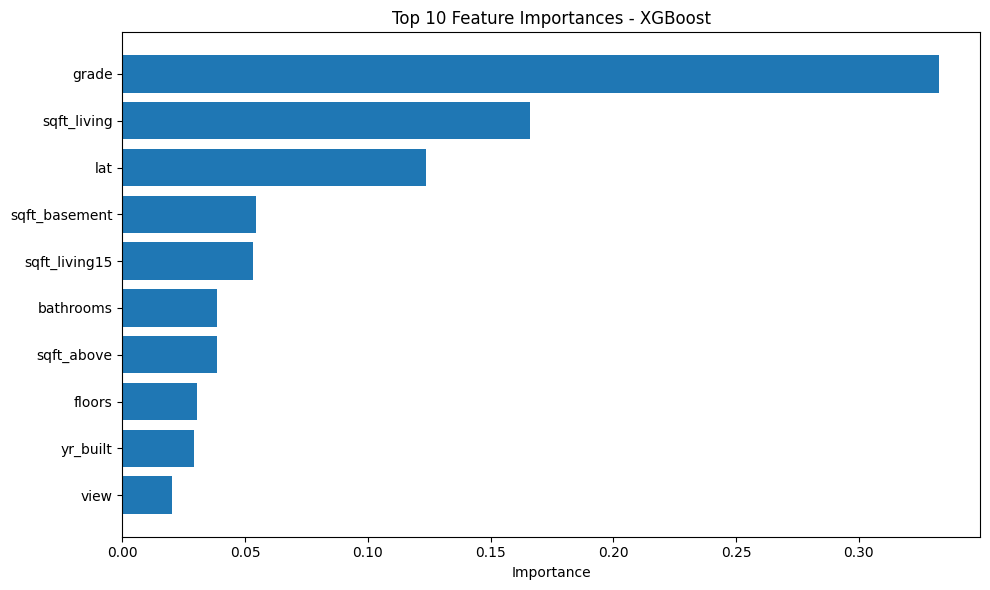

In [21]:
feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': xgb_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTop 10 Most Important Features:")
print(feature_importance.head(10))

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(range(10), feature_importance['importance'].head(10))
plt.yticks(range(10), feature_importance['feature'].head(10))
plt.xlabel('Importance')
plt.title('Top 10 Feature Importances - XGBoost')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [22]:
base_extractor = ResNet50(
    include_top=False,
    weights='imagenet',
    input_shape=(128, 128, 3)
)

# Freeze all layers
for layer in base_extractor.layers:
    layer.trainable = False

# Add pooling to get feature vector
x = base_extractor.output
x = layers.GlobalAveragePooling2D()(x)

feature_extractor = Model(
    inputs=base_extractor.input,
    outputs=x,
    name='image_feature_extractor'
)

print("Feature extractor created!")
print(f"Output shape: {feature_extractor.output.shape}")

Feature extractor created!
Output shape: (None, 2048)


In [23]:
print("Extracting image features...")
train_img_features = feature_extractor.predict(train_images_eff, verbose=1)
val_img_features = feature_extractor.predict(val_images_eff, verbose=1)
test_img_features = feature_extractor.predict(test_images_eff, verbose=1)

to_predict_img_features = feature_extractor.predict(to_predict_images_eff, verbose = 1)

print(f"Train image features shape: {train_img_features.shape}")
print(f"Val image features shape: {val_img_features.shape}")
print(f"Test image features shape: {test_img_features.shape}")

Extracting image features...
406/406 ━━━━━━━━━━━━━━━━━━━━ 59s 141ms/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 7s 141ms/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 7s 135ms/step
169/169 ━━━━━━━━━━━━━━━━━━━━ 24s 141ms/step
Train image features shape: (12967, 2048)
Val image features shape: (1621, 2048)
Test image features shape: (1621, 2048)


In [24]:
X_train_combined = np.hstack([X_train_scaled, train_img_features])
X_val_combined = np.hstack([X_val_scaled, val_img_features])
X_test_combined = np.hstack([X_test_scaled, test_img_features])

to_predict_combined = np.hstack([to_predict_scaled, to_predict_img_features])

print(f"Combined training features shape: {X_train_combined.shape}")
print(f"Combined validation features shape: {X_val_combined.shape}")
print(f"Combined test features shape: {X_test_combined.shape}")

Combined training features shape: (12967, 2066)
Combined validation features shape: (1621, 2066)
Combined test features shape: (1621, 2066)


In [25]:
xgb_combined_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    eval_metric='rmse',
    max_depth=8,
    learning_rate=0.05,
    n_estimators=500,
    subsample=0.8,
    colsample_bytree=0.8,
    min_child_weight=3,
    gamma=0.1,
    reg_alpha=0.1,
    reg_lambda=1.0,
    random_state=42,
    early_stopping_rounds=50,
    n_jobs=-1
)

xgb_combined_model.fit(
    X_train_combined, y_train,
    eval_set=[(X_train_combined, y_train), (X_val_combined, y_val)],
    verbose=50
)

[0]	validation_0-rmse:0.21801	validation_1-rmse:0.21855
[50]	validation_0-rmse:0.07009	validation_1-rmse:0.08247
[100]	validation_0-rmse:0.06189	validation_1-rmse:0.07504
[150]	validation_0-rmse:0.06143	validation_1-rmse:0.07459
[200]	validation_0-rmse:0.06127	validation_1-rmse:0.07445
[239]	validation_0-rmse:0.06126	validation_1-rmse:0.07445


,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8
,device,None
,early_stopping_rounds,50
,enable_categorical,False
,eval_metric,'rmse'


In [26]:
y_pred_xgb_combined = xgb_combined_model.predict(X_test_combined)

mse_xgb_combined = mean_squared_error(y_test, y_pred_xgb_combined)
rmse_xgb_combined = np.sqrt(mse_xgb_combined)
mae_xgb_combined = mean_absolute_error(y_test, y_pred_xgb_combined)
r2_xgb_combined = r2_score(y_test, y_pred_xgb_combined)
mape_xgb_combined = np.mean(np.abs((y_test - y_pred_xgb_combined) / y_test)) * 100

print(f"Root Mean Squared Error: {rmse_xgb_combined:.4f}")
print(f"Mean Absolute Error: {mae_xgb_combined:.4f}")
print(f"R2 Score: {r2_xgb_combined:.4f}")
print(f"MAPE: {mape_xgb_combined:.2f}%")

Root Mean Squared Error: 0.0768
Mean Absolute Error: 0.0557
R2 Score: 0.8871
MAPE: 0.99%


            Model     RMSE      MAE       R2  MAPE (%)
         ResNet50 0.101606 0.077453 0.802565  1.360424
XGBoost (Tabular) 0.074568 0.054755 0.893662  0.969388
 XGBoost + Images 0.076831 0.055715 0.887109  0.988128


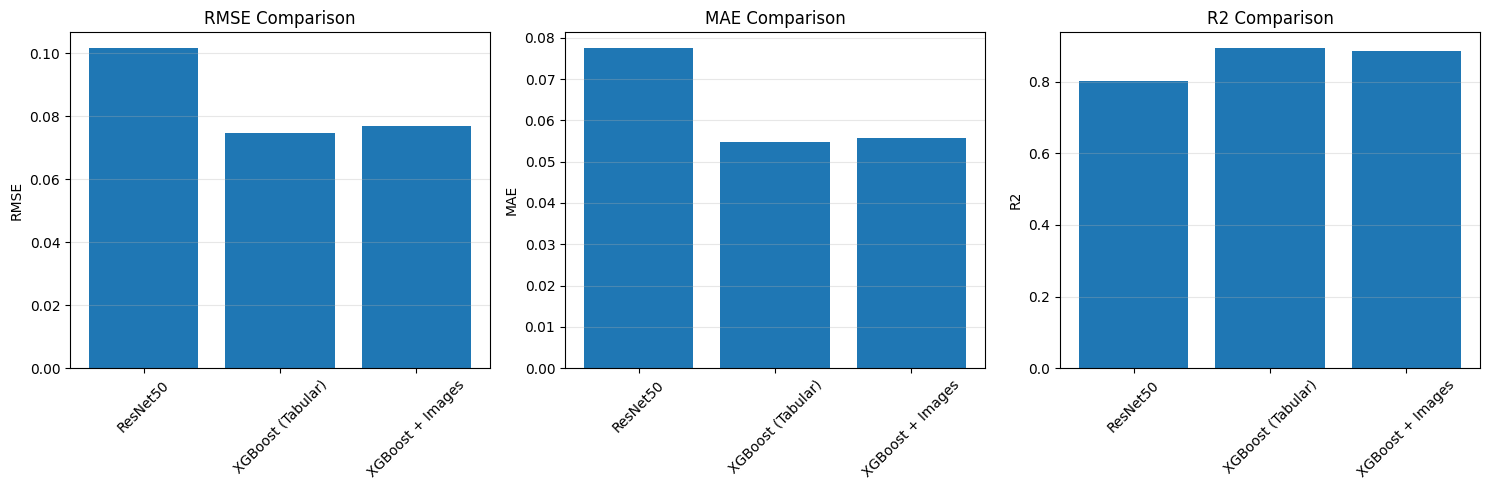

In [38]:
comparison_data = {
    'Model': [
        'ResNet50',
        'XGBoost (Tabular)',
        'XGBoost + Images'
    ],
    'RMSE': [
        rmse,
        rmse_xgb,
        rmse_xgb_combined
    ],
    'MAE': [
        mae,
        mae_xgb,
        mae_xgb_combined
    ],
    'R2': [
        r2,
        r2_xgb,
        r2_xgb_combined
    ],
    'MAPE (%)': [
        mape,
        mape_xgb,
        mape_xgb_combined
    ]
}

comparison_df = pd.DataFrame(comparison_data)
print(comparison_df.to_string(index=False))
print("="*70)

# Visualize comparison
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

metrics = ['RMSE', 'MAE', 'R2']
for idx, metric in enumerate(metrics):
    axes[idx].bar(comparison_df['Model'], comparison_df[metric])
    axes[idx].set_ylabel(metric)
    axes[idx].set_title(f'{metric} Comparison')
    axes[idx].tick_params(axis='x', rotation=45)
    axes[idx].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()